In [1]:
import os.path, sys

import numpy as np
import pandas as pd
from scipy import linalg
from scipy.sparse import csr_matrix
from sklearn.preprocessing import OneHotEncoder

import Bio.PDB, warnings
pdb_list = Bio.PDB.PDBList()
pdb_parser = Bio.PDB.PDBParser()
from scipy.spatial import distance_matrix
from Bio import BiopythonWarning
warnings.simplefilter('ignore', BiopythonWarning)

from joblib import Parallel, delayed
import timeit

import matplotlib.pyplot as plt

# # --- Import our Code ---# #
#import emachine as EM
from direct_info import direct_info

# import data processing and general DCA_ER tools
from data_processing import data_processing_msa2pdb
import ecc_tools as tools
from pathlib import Path
np.random.seed(1)

from Bio import SeqIO
from Bio.PDB import *
from scipy.spatial import distance_matrix
from Bio import pairwise2
#from Bio.SubsMat.MatrixInfo import blosum62
pdb_parser = Bio.PDB.PDBParser()
from data_processing import pdb2msa, data_processing_pdb2msa

from prody import *

import gzip, shutil
def gunzip(file_path, output_path):
    print('Unzipping %s to %s' % (file_path, output_path))
    with gzip.open(file_path,"rb") as f_in, open(output_path,"wb") as f_out:
        shutil.copyfileobj(f_in, f_out)

from umap.parametric_umap import ParametricUMAP
from sklearn.decomposition import PCA


In [2]:
create_new = False
printing = True
removing_cols = True
remove_diagonals = False

pdb_id = "1r1o"
pdb_id = '2a78'
pdb_id = "1I8G"
pdb_id = "1zdr"

pdb_path = "/pdb/pdb/%s/pdb%s.ent.gz" % (pdb_id.lower()[1:3], pdb_id.lower())
data_path = Path('/data/cresswellclayec/Pfam-A.full')

# Define data directories
DCA_ER_dir = '/data/cresswellclayec/DCA_ER' # Set DCA_ER directory
biowulf_dir = '%s/biowulf_full' % DCA_ER_dir


out_dir = '%s/protein_data/di/' % biowulf_dir
out_metric_dir = '%s/protein_data/metrics/' % biowulf_dir

processed_data_dir = "%s/protein_data/data_processing_output/" % biowulf_dir
pdb_dir = '%s/protein_data/pdb_data/' % biowulf_dir

pdb_data_file = '%s/%s_pdb_df.csv' % (pdb_dir, pdb_id)

if os.path.exists(pdb_data_file):
    prody_df = pd.read_csv(pdb_data_file)
    pdb_file = "%spdb%s.ent" % (pdb_dir,pdb_id)


    pdb2msa_row = prody_df.iloc[0]
    pfam_id = pdb2msa_row['Pfam']
    pdb_chain = pdb2msa_row['Chain']
#     print(pdb2msa_row)
else:
    unzipped_pdb_filename = os.path.basename(pdb_path).replace(".gz", "")

    pdb_out_path = "%s%s" % (pdb_dir, unzipped_pdb_filename)
    print('Unzipping %s to %s' % (pdb_path, pdb_out_path))

    gunzip(pdb_path, pdb_out_path)
    pdb2msa_results = pdb2msa(pdb_out_path, pdb_dir, create_new=False)

    if len(pdb2msa_results) > 1:                                                                         
        fasta_file = pdb2msa_results[0]
        prody_df = pdb2msa_results[1]
    else:                                                                                                
        prody_df = pdb2msa_results[0]



pdb2msa_row  = prody_df.iloc[0]
print('\n\nGetting msa with following pdb2msa entry:\n', pdb2msa_row)
#try:
print(pdb2msa_row)
pfam_id = pdb2msa_row['Pfam']
pdb_id = pdb2msa_row['PDB ID']
pdb_chain = pdb2msa_row['Chain']

ref_outfile = Path(processed_data_dir, '%s_ref.fa' % pfam_id)

pfam_dimensions_file = "%s/%s_%s_pfam_dimensions.npy" % (processed_data_dir, pdb_id, pfam_id)
pfam_dimensions = np.load(pfam_dimensions_file)
if len(pfam_dimensions)==7:
    [n_col, n_seq, m_eff, ct_ER, ct_MF, ct_PMF, ct_PLM] = pfam_dimensions
elif len(pfam_dimensions)==6: # new pfam_dimensions created in run_method_comparison. we dont need MF..
    [n_col, n_seq, m_eff, ct_ER, ct_PMF, ct_PLM] = pfam_dimensions
elif len(pfam_dimensions)==3:
    [n_col, n_seq, m_eff] = pfam_dimensions




Getting msa with following pdb2msa entry:
 Unnamed: 0                                                           0
PDB ID                                                            1zdr
Chain                                                                B
Polypeptide Index                                                    0
Pfam                                                           PF00186
accession                                                   PF00186.22
class                                                           Domain
id                                                              DHFR_1
type                                                            Pfam-A
PDB Sequence         MISHIVAMDENRVIGKDNRLPWHLPADLAYFKRVTMGHAIVMGRKT...
ali_end                                                            160
ali_start                                                            1
bitscore                                                        215.11
end                             

In [3]:
w_file = "%s/%s_%s_w.npy" % (processed_data_dir, pdb_id, pfam_id)
w_ER = np.load(w_file)
print(w_ER.shape)
print('w_ER Symmetric: ', (w_ER==w_ER.T).all())

(1664, 1664)
w_ER Symmetric:  True


In [4]:
import pickle
if not os.path.exists('%s/%s_processed_data.npy' % (pdb_dir, pdb_id)):
    # we need mx.cumsum
    # also this needs to be rerunn since we deleted processed pdb2msa data.
    rows_to_drop = []
    for ir, pdb2msa_row in enumerate(prody_df.iterrows()):
        print('\n\nGetting msa with following pdb2msa entry:\n', pdb2msa_row)
        try:
            dp_result =  data_processing_pdb2msa(data_path, prody_df.iloc[pdb2msa_row[0]], gap_seqs=0.2, gap_cols=0.2, prob_low=0.004,
                                   conserved_cols=0.8, printing=True, out_dir=processed_data_dir, pdb_dir=pdb_dir, letter_format=False,
                                   remove_cols=True, create_new=True)
            if dp_result is not None:
                [s0, removed_cols, s_index, tpdb, pdb_s_index] = dp_result
                break
            else:
                rows_to_drop.append(ir)
                continue
        except Exception as e:
            print('row %d got exception: ' % ir , e)
            print('moving on.. ')
            pass

    pdb_id = pdb2msa_row[1]['PDB ID']
    pfam_id = pdb2msa_row[1]['Pfam']
    # update Prody search DF (use same filename as pdb2msa() in data_processing 
    if not os.path.exists(pdb_data_file):
        prody_df = prody_df.drop(rows_to_drop)                                                     
    print("\nSaving updated Prody Search DataFrame:", prody_df.head())
    prody_df.to_csv('%s/%s_pdb_df.csv' % (pdb_dir, pdb_id))
    with open('%s/%s_processed_data.npy' % (pdb_dir, pdb_id), 'wb') as f:
        pickle.dump(dp_result, f)
        f.close()
else:
    with open('%s/%s_processed_data.npy' % (pdb_dir, pdb_id), 'rb') as f:
        dp_result = pickle.load(f)
        f.close()
[s0, removed_cols, s_index, tpdb, pdb_s_index] = dp_result



In [5]:
# number of positions
n_var = s0.shape[1]
n_seq = s0.shape[0]

print("Number of residue positions:",n_var)
print("Number of sequences:",n_seq)

# number of aminoacids at each position
mx = np.array([len(np.unique(s0[:,i])) for i in range(n_var)])
#mx = np.array([m for i in range(n_var)])
print("Number of different amino acids at each position",mx)

mx_cumsum = np.insert(mx.cumsum(),0,0)
i1i2 = np.stack([mx_cumsum[:-1],mx_cumsum[1:]]).T
# print("(Sanity Check) Column indices of first and (",i1i2[0],") and last (",i1i2[-1],") positions")
# print("(Sanity Check) Column indices of second and (",i1i2[1],") and second to last (",i1i2[-2],") positions")


# number of variables
mx_sum = mx.sum()
print("Total number of variables",mx_sum)

# number of bias term
n_linear = mx_sum - n_var

onehot_encoder = OneHotEncoder(sparse=False,categories='auto')
# s is OneHot encoder format, s0 is original sequnce matrix
s = onehot_encoder.fit_transform(s0)


Number of residue positions: 132
Number of sequences: 6535
Number of different amino acids at each position [ 6 16 12  7  8 15  8 17 12 14  9 19 11 10 13  5  5 14  9  5 11  9 12 10
  9 10 16 17 11 12 13  5  4  9  7 11  5 10 12  9  9 17  8  7  5  2 11 18
 18 20 20 20 14 13 15 16 15 14 14  7 12 15 12  8 15 15 21 19 16 16 20 15
 17 13 11  8 10 11 13  4  3 13 15 12 11 13 19  9 11 17  7 14  8 16  3 15
 19 15 14 15  7  7 15  7 17 10 16 20 17 18  5 17 16 17 19 19 18 21 21 19
 15 17 13 16 13 14 10 14  9 18 14  5]
Total number of variables 1664


In [6]:
from scipy.spatial import distance

def E(i1i2, s, w):
    E = 0
    s_len = len(i1i2)
    for i in range(s_len):
        i1,i2 = i1i2[i,0],i1i2[i,1]
        si_vec = s[i1:i2]
        for j in range(s_len):
            j1,j2 = i1i2[j,0],i1i2[j,1]
            sj_vec = s[j1:j2]
            E += np.dot(si_vec, np.dot(w[i1:i2,j1:j2], np.transpose(sj_vec)))
    return E

print(E(i1i2, s[1,:], w_ER))


def energy_diff(i1i2, s1, s2, w):
    e_diff = 0.
    s_len = len(i1i2)

    E1 = E(i1i2, s1, w)
    E2 = E(i1i2, s2, w)
    #print(E1)
    #print(E2)
    
    e_diff1 = 0
    for i in range(s_len):
        i1,i2 = i1i2[i,0],i1i2[i,1]
        si_vec = s1[i1:i2]
        for j in range(s_len):
            j1,j2 = i1i2[j,0],i1i2[j,1]
            sj_vec = s2[j1:j2]
            e_diff1 += np.dot(si_vec, np.dot(w[i1:i2,j1:j2], np.transpose(sj_vec)))
    
    e_diff2 = 0
    for i in range(s_len):
        i1,i2 = i1i2[i,0],i1i2[i,1]
        si_vec = s2[i1:i2]
        for j in range(s_len):
            j1,j2 = i1i2[j,0],i1i2[j,1]
            sj_vec = s1[j1:j2]
            e_diff2 += np.dot(si_vec, np.dot(w[i1:i2,j1:j2], np.transpose(sj_vec)))
    return E1 + E2 - e_diff1 - e_diff2   


print('identity energy difference: ', energy_diff(i1i2,s[1,:],s[1,:],w_ER))
print('seq 1 vs 2 energy difference: ', energy_diff(i1i2,s[1,:],s[2,:],w_ER))
print('seq 1 vs seq2 hamming distance: ', distance.squareform(distance.pdist(s[1:3,:], 'hamming')))
print(distance.squareform(distance.pdist([s[1,:],s[2,:]], 'hamming'))[0][1])

566.0630652891111
identity energy difference:  0.0
seq 1 vs 2 energy difference:  880.1332835296125
seq 1 vs seq2 hamming distance:  [[0.         0.11899038]
 [0.11899038 0.        ]]
0.11899038461538461


In [7]:
# num_datapoints = n_seq
num_datapoints = int(np.floor(.5 * n_seq))

print(num_datapoints)
data_dim = len(s[1]) - len(i1i2)

latent_dim = 100
print('data points: %d, data dimension: %d, latent dimension: %d' % (num_datapoints, data_dim, latent_dim))

import functools
import warnings

import matplotlib.pyplot as plt
import numpy as np

# import tensorflow.compat.v2 as tf
# import tensorflow_probability as tfp

# from tensorflow_probability import bijectors as tfb
# from tensorflow_probability import distributions as tfd

# tf.enable_v2_behavior()

# plt.style.use("ggplot")
warnings.filterwarnings('ignore')


seq_wt_file = '%s/seq_weight_%s_%s.npy' % (processed_data_dir, pdb_id, pfam_id)
if os.path.exists(seq_wt_file):
    seqs_weight = np.load(seq_wt_file)
    print('seqs weights: ', seqs_weight.shape)
else:
    pass
# remove last onehot row for each column 
# number of aminoacids at each position
mx_alt = np.array([len(np.unique(s0[:,i]))-1 for i in range(n_var)])
mx_cumsum_alt = np.insert(mx_alt.cumsum(),0,0)
i1i2_alt = np.stack([mx_cumsum_alt[:-1],mx_cumsum_alt[1:]]).T
last_onehots = [val -1  for val in mx_cumsum[1:]]

s_alt = np.delete(s, last_onehots, axis=1)
print('original onehot data shape: ', s.shape)
print('adjusted onehot data shape:' , s_alt.shape)

# randomly sample seqeuneces based off weight.
print(seqs_weight, np.sum(seqs_weight))
print(seqs_weight / np.sum(seqs_weight))
np.random.seed(1234)
from numpy.random import choice
s_train_indices = choice([i for i in range(len(s))], num_datapoints, p=seqs_weight/np.sum(seqs_weight), replace=False)
s_test_indices =  [i for i in range(len(s)) if i not in s_train_indices]

# s_train = s_alt[:num_datapoints]
print(s_train_indices[:5])
# print([seqs_weight[i] for i in range(len(seqs_weight)) if i in s_train_indices])


# re-order amino-acid matrix
s_alt_reordered = s_alt.copy()
s_alt_reordered[:len(s_train_indices)] = s_alt[s_train_indices]
s_alt_reordered[len(s_train_indices):] = s_alt[s_test_indices]

s_reordered = s.copy()
s_reordered[:len(s_train_indices)] = s[s_train_indices]
s_reordered[len(s_train_indices):] = s[s_test_indices]

s_reordered_indices = np.zeros(len(s_alt))
s_reordered_indices[:len(s_train_indices)] = s_train_indices 
s_reordered_indices[len(s_train_indices):] = s_test_indices



# re-order s so that s_train is the first set of points.
s_train = s_alt[s_train_indices]
# s_train = s[s_train_indices]
sT = np.transpose(s_train)


w_ER_alt = np.delete(w_ER, last_onehots, axis=1)
w_ER_alt = np.delete(w_ER_alt, last_onehots, axis=0)

print(len(s[1]), len(i1i2))
print(sT.shape)
print('w_ER_alt Symmetric: ', (w_ER_alt==w_ER_alt.T).all())

3267
data points: 3267, data dimension: 1532, latent dimension: 100
seqs weights:  (6535,)
original onehot data shape:  (6535, 1664)
adjusted onehot data shape: (6535, 1532)
[1.   0.25 1.   ... 1.   1.   1.  ] 4818.003084807781
[2.07554869e-04 5.18887173e-05 2.07554869e-04 ... 2.07554869e-04
 2.07554869e-04 2.07554869e-04]
[1268 4056 2874 5133 5097]
1664 132
(1532, 3267)
w_ER_alt Symmetric:  True


In [8]:
res_ham  = distance.squareform(distance.pdist(s_reordered[:100], 'hamming'))    

In [9]:
def PCA_perturb_old(seqs, pca, mag=1., pc_num=1):
#     mag = mag * pca.explained_variance_[pc_num]

    new_seqs = pca.transform(seqs) 
    new_seqs[:,pc_num] +=  mag

    new_seqs_full = pca.inverse_transform(new_seqs)
    return new_seqs, new_seqs_ful
def PCA_perturb(seqs, pca, mag=1., pc_num=1, components=None):
    if components is None:
        dir_vec = pca.components_[pc_num] 
    else:
        dir_vec = components[pc_num]
    new_seqs =  seqs.copy()
    for i, seq in enumerate(seqs):
        new_seqs[i] = seqs[i] + mag * dir_vec
        
    return new_seqs

original sequences shape:  (3267, 1532)
pca-embed:  (2, 1532)


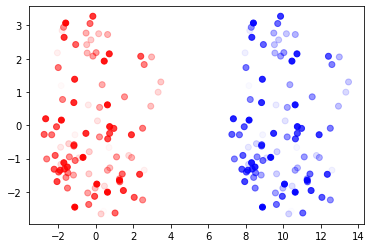

In [10]:
# 2 D example to prove we're doing what we think we're doing

pca = PCA(n_components=2)  
pca_s = pca.fit_transform(s_train)
print('original sequences shape: ', s_train.shape)
print('pca-embed: ', pca.components_.shape)


move_dim = 0
translated_seqs_full = PCA_perturb(s_train[:100], pca, mag=10., pc_num=move_dim)
translated_seqs = pca.transform(translated_seqs_full)

fig = plt.figure()
plt.scatter(pca_s[:100,0], pca_s[:100,1], color='red',alpha = [.01*i for i in range(100)], label='PCA projected Sequences ')
plt.scatter(translated_seqs[:,0], translated_seqs[:,1], alpha = [.01*i for i in range(100)], color='blue',  label='PCA translated (%d reduced dimension) Sequences' % move_dim)
plt.show()

[-20.         -17.89473684 -15.78947368 -13.68421053 -11.57894737
  -9.47368421  -7.36842105  -5.26315789  -3.15789474  -1.05263158
   1.05263158   3.15789474   5.26315789   7.36842105   9.47368421
  11.57894737  13.68421053  15.78947368  17.89473684  20.        ]


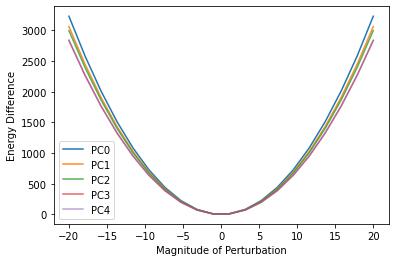

In [11]:
latent_dim = 5
pert_mags = np.linspace(-20,20, num=20)
print(pert_mags)
# get sequence set
sequence_set = s_train[:2]

# fit pca model to full sequence set: s_train
pca_perturb = PCA(n_components=latent_dim)
pca_perturb_s = pca_perturb.fit_transform(s_train)

energy_vs_pc = []
for move_dim in range(latent_dim):
    trans_seq_full_mag = []
    energy_vs_pc.append([])
    for i,mag in enumerate(pert_mags):    
        trans_seq_full_out = PCA_perturb(sequence_set, pca_perturb, mag=mag, pc_num=move_dim)
        trans_seq_full_mag.append(trans_seq_full_out[0])  
    for trans_seq_full in trans_seq_full_mag:
         energy_vs_pc[-1].append(energy_diff(i1i2,trans_seq_full,sequence_set[0],w_ER_alt))

fig = plt.figure()
for i in range(latent_dim):
    plt.plot(pert_mags, energy_vs_pc[i], alpha = 1-.1*i, label='PC%d' % i)
#     print(energy_vs_pc[i])  # shows they are NOT SYMMETRIC
plt.xlabel('Magnitude of Perturbation')
plt.ylabel('Energy Difference')
plt.legend()
plt.show()

In [12]:
trans_seq_full = []
for i,mag in enumerate(pert_mags):    
    trans_seq_full.append([])
    for move_dim in range(latent_dim):
        trans_seq_full_out = PCA_perturb(sequence_set, pca_perturb, mag=mag, pc_num=move_dim)
        trans_seq_full[-1].append(trans_seq_full_out[0])  
print(np.array(trans_seq_full).shape)

(20, 5, 1532)


2022-11-16 10:32:35.517870: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-16 10:32:37.266200: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-11-16 10:32:37.276154: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2300000000 Hz


Epoch 1/10
1063/1063 [==============================] - 9s 7ms/step - loss: 0.2119
Epoch 2/10
1063/1063 [==============================] - 7s 7ms/step - loss: 0.1381
Epoch 3/10
1063/1063 [==============================] - 7s 7ms/step - loss: 0.1362
Epoch 4/10
1063/1063 [==============================] - 7s 7ms/step - loss: 0.1346
Epoch 5/10
1063/1063 [==============================] - 7s 7ms/step - loss: 0.1339
Epoch 6/10
1063/1063 [==============================] - 7s 7ms/step - loss: 0.1329
Epoch 7/10
1063/1063 [==============================] - 7s 7ms/step - loss: 0.1327
Epoch 8/10
1063/1063 [==============================] - 7s 7ms/step - loss: 0.1328
Epoch 9/10
1063/1063 [==============================] - 7s 7ms/step - loss: 0.1323
Epoch 10/10
1063/1063 [==============================] - 7s 7ms/step - loss: 0.1321


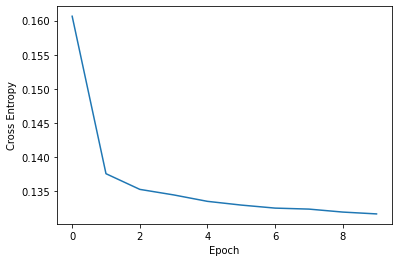

In [13]:
# get umap of sequence space --> 3D
embedder = ParametricUMAP(n_components = latent_dim, random_state=42)
embedding = embedder.fit(s_train)

fig, ax = plt.subplots()
ax.plot(embedder._history['loss'])
ax.set_ylabel('Cross Entropy')
ax.set_xlabel('Epoch')
plt.show()

(3267, 1532)
(6535, 1532)
(6535, 5)
5
translated sequence full dim:  (5, 1532)
(10, 5, 5)
(10, 5, 5)


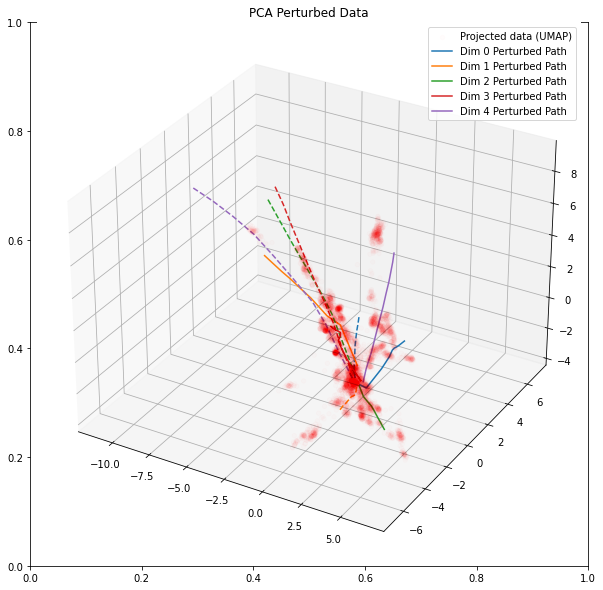

In [14]:
s_proj_umap = embedder.transform(s_alt_reordered)

print(s_train.shape)
print(s_alt_reordered.shape)
print(s_proj_umap.shape)
perturb_path_full = np.array(trans_seq_full)
print(latent_dim)
print('translated sequence full dim: ', np.array(trans_seq_full[i]).shape)

perturb_path_mag = []
perturb_path_mag_neg = []

for i,mag in enumerate(pert_mags):
    if mag>=0:
        perturb_path_mag.append(embedder.transform(trans_seq_full[i]))
    else:
        perturb_path_mag_neg.append(embedder.transform(trans_seq_full[i]))
perturb_path_mag = np.array(perturb_path_mag)
perturb_path_mag_neg = np.array(perturb_path_mag_neg)
print(perturb_path_mag.shape)
print(perturb_path_mag_neg.shape)


fig = plt.figure(figsize=(10,10))
plt.title('PCA Perturbed Data')
ax = plt.axes(projection='3d')
ax.scatter(s_proj_umap[:,0], s_proj_umap[:,1], s_proj_umap[:,2], color='red', alpha=0.01, label='Projected data (UMAP)')
dim_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
for move_dim in range(latent_dim):
    ax.plot(perturb_path_mag[:,move_dim,0], perturb_path_mag[:,move_dim,1], perturb_path_mag[:,move_dim,2], color=dim_colors[move_dim],  label='Dim %d Perturbed Path' % move_dim)
    ax.plot(perturb_path_mag_neg[:,move_dim,0], perturb_path_mag_neg[:,move_dim,1], perturb_path_mag_neg[:,move_dim,2], color=dim_colors[move_dim], linestyle='--')

plt.legend()
plt.show()

In [15]:
def ER_transform(seqs, v):
    new_seqs = seqs @ v.T
    return new_seqs

def ER_inverse_transform(seqs, v):
    new_seqs = seqs @ v
def ER_perturb_old(seqs, w, v, mag=1., ev_direction=0):
    
    x_centered = seqs - seqs.mean(axis=0)

    new_seqs = ER_transform(x_centered, v) 
    new_seqs[:,ev_direction] +=  mag

    new_seqs_full = ER_inverse_transform(new_seqs, v)

    return new_seqs, new_seqs_full
def ER_perturb(seqs, w, v, pert_mag=1., pert_dir=0):

    dir_vec = v[pert_dir] 
    new_seqs =  seqs.copy()
    if len(new_seqs.shape)> 1:
        for i, seq in enumerate(seqs):
            # print(np.add(seqs[i], pert_mag * dir_vec).shape)
            new_seqs[i,:] = seqs[i] + pert_mag * dir_vec
    else:
#         new_seqs = np.add(seqs, pert_mag * dir_vec)
        new_seqs = seqs + pert_mag * dir_vec

    return new_seqs

In [16]:
w, v  = np.linalg.eig(w_ER_alt)
print(w.shape)
print(v.shape)

trans_seq_full_out = ER_perturb(s_alt_reordered[0], w, v, pert_mag=0, pert_dir=0)

print(sequence_set.shape)
print(trans_seq_full_out.shape)
print(sequence_set[0,:10])
print(trans_seq_full_out[:10])

(1532,)
(1532, 1532)
(2, 1532)
(1532,)
[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]


[-100.          -89.47368421  -78.94736842  -68.42105263  -57.89473684
  -47.36842105  -36.84210526  -26.31578947  -15.78947368   -5.26315789
    5.26315789   15.78947368   26.31578947   36.84210526   47.36842105
   57.89473684   68.42105263   78.94736842   89.47368421  100.        ]


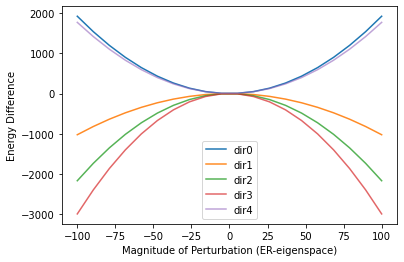

In [17]:
pert_mags = np.linspace(-100,100, num=20)
print(pert_mags)
ref_seq = s_alt_reordered[0]

energy_vs_w_ERperturb = []
for move_dim in range(latent_dim):
    trans_seq_full_mag = []
    energy_vs_w_ERperturb.append([])
    for i,mag in enumerate(pert_mags):    
        trans_seq_full_out = ER_perturb(ref_seq, w, v, pert_mag=mag, pert_dir=move_dim)
        trans_seq_full_mag.append(trans_seq_full_out)  
    for trans_seq_full in trans_seq_full_mag:
         energy_vs_w_ERperturb[-1].append(energy_diff(i1i2,trans_seq_full,ref_seq,w_ER_alt))

fig = plt.figure()
for i in range(latent_dim):
    plt.plot(pert_mags, energy_vs_w_ERperturb[i], alpha = 1-.1*i, label='dir%d' % i)
#     print(energy_vs_pc[i])  # shows they are NOT SYMMETRIC
plt.xlabel('Magnitude of Perturbation (ER-eigenspace)')
plt.ylabel('Energy Difference')
plt.legend()
plt.show()

In [18]:
wER_trans_seq_full = []
for i,mag in enumerate(pert_mags):    
    wER_trans_seq_full.append([])
    for move_dim in range(latent_dim):
        trans_seq_full_out = ER_perturb(ref_seq, w,v, pert_mag=mag, pert_dir=move_dim)
        wER_trans_seq_full[-1].append(trans_seq_full_out)  


(10, 5, 5)
(10, 5, 5)


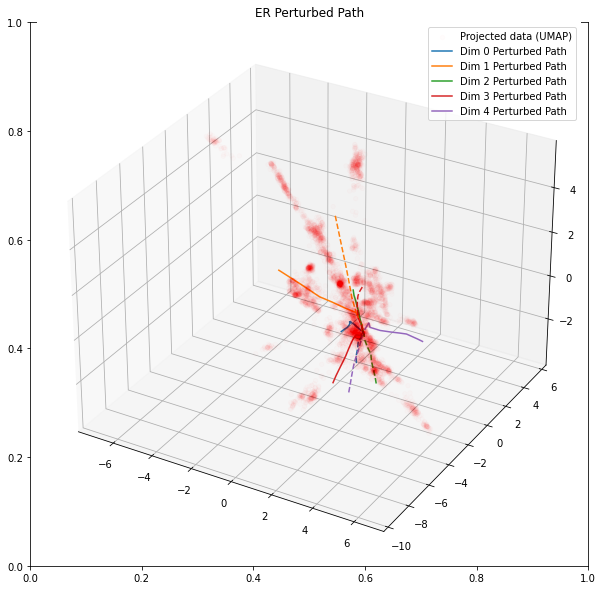

In [19]:
wER_perturb_path_mag = []
wER_perturb_path_mag_neg = []

for i,mag in enumerate(pert_mags):
    if mag>=0:
        wER_perturb_path_mag.append(embedder.transform(wER_trans_seq_full[i]))
    else:
        wER_perturb_path_mag_neg.append(embedder.transform(wER_trans_seq_full[i]))
wER_perturb_path_mag = np.array(wER_perturb_path_mag)
wER_perturb_path_mag_neg = np.array(wER_perturb_path_mag_neg)
print(wER_perturb_path_mag.shape)
print(wER_perturb_path_mag_neg.shape)


fig = plt.figure(figsize=(10,10))
plt.title('ER Perturbed Path')
ax = plt.axes(projection='3d')
ax.scatter(s_proj_umap[:,0], s_proj_umap[:,1], s_proj_umap[:,2], color='r', alpha=0.01, label='Projected data (UMAP)')
dim_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
for move_dim in range(latent_dim):
    ax.plot(wER_perturb_path_mag[:,move_dim,0], wER_perturb_path_mag[:,move_dim,1], wER_perturb_path_mag[:,move_dim,2], color=dim_colors[move_dim],  label='Dim %d Perturbed Path' % move_dim)
    ax.plot(wER_perturb_path_mag_neg[:,move_dim,0], wER_perturb_path_mag_neg[:,move_dim,1], wER_perturb_path_mag_neg[:,move_dim,2], color=dim_colors[move_dim], linestyle='--')

plt.legend()
plt.show()

In [20]:
from scipy.spatial import distance
import expectation_reflection as ER

# Define wight matrix with variable for each possible amino acid at each sequence position
w_ER_wt = np.zeros((mx.sum(),mx.sum())) 
h0_wt = np.zeros(mx.sum())
from scipy.spatial import distance

dst = distance.squareform(distance.pdist(s0, 'hamming'))
ma_inv = 1/(1+(dst < .2).sum(axis=1).astype(float))
print(ma_inv.shape)
print(s.shape)
#-------------------------------
# parallel
start_time = timeit.default_timer()
#res = Parallel(n_jobs = 4)(delayed(predict_w)\
#res = Parallel(n_jobs = 8)(delayed(predict_w)\

# Expectation Reflection
#=========================================================================================
def predict_w(s,i0,i1i2,niter_max,l2):
    #print('i0:',i0)
    i1,i2 = i1i2[i0,0],i1i2[i0,1]

    x = np.hstack([s[:,:i1],s[:,i2:]])
    y = s[:,i1:i2]

    h01,w1 = ER.fit(x,y,niter_max,l2)

    return h01,w1


s_wt = s.copy()
for i,seq in enumerate(s):
    s_wt[i,:] = ma_inv[i]* seq
print(ma_inv[:5])
print(s_wt[:5,:40])
    
res = Parallel(n_jobs = 18)(delayed(predict_w)\
        (s_wt,i0,i1i2,niter_max=10,l2=100.0)\
        for i0 in range(n_var))

run_time = timeit.default_timer() - start_time
print('run time:',run_time)
## This above line seems wrong, seems like the following for loop should be moved up?? not sure if this is some 
## python implementation or just wrong
#-------------------------------
for i0 in range(n_var):
    i1,i2 = i1i2[i0,0],i1i2[i0,1]

    h01 = res[i0][0]
    w1 = res[i0][1]

    h0_wt[i1:i2] = h01
    w_ER_wt[:i1,i1:i2] = w1[:i1,:]
    w_ER_wt[i2:,i1:i2] = w1[i1:,:]

# make w symmetric
w_ER_wt = (w_ER_wt + w_ER_wt.T)/2.
w_ER_wt_alt = np.delete(w_ER_wt, last_onehots, axis=1)
w_ER_wt_alt = np.delete(w_ER_wt_alt, last_onehots, axis=0)

(6535,)
(6535, 1664)
[0.5        0.2        0.5        0.07692308 0.5       ]
[[0.         0.5        0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.5
  0.         0.         0.         0.         0.         0.
  0.5        0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.5        0.        ]
 [0.         0.         0.2        0.         0.         0.
  0.2        0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.2        0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.2        0.        ]
 [0.         0.         0.         0.         0.         0.5
  0.         0.         0.         0.         

/data/cresswellclayec/conda/envs/DCA_ER/lib/python3.9/site-packages/Bio/SubsMat/__init__.py:126: BiopythonDeprecationWarning: Bio.SubsMat has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.substitution_matrices as a replacement, and contact the Biopython developers if you still need the Bio.SubsMat module.
  warnings.warn(
/data/cresswellclayec/conda/envs/DCA_ER/lib/python3.9/site-packages/Bio/SubsMat/__init__.py:126: BiopythonDeprecationWarning: Bio.SubsMat has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.substitution_matrices as a replacement, and contact the Biopython developers if you still need the Bio.SubsMat module.
  warnings.warn(
/data/cresswellclayec/conda/envs/DCA_ER/lib/python3.9/site-packages/Bio/SubsMat/__init__.py:126: BiopythonDeprecationWarning: Bio.SubsMat has been deprecated, and we intend to remove it 

run time: 147.2028235130001


## Weighted ER

[[ 0.          0.          0.         ... -0.05988825 -0.0014778
   0.11899215]
 [ 0.          0.          0.         ... -0.03716875  0.08560031
  -0.08561484]
 [ 0.          0.          0.         ...  0.20411513 -0.01524124
   0.05414457]
 ...
 [-0.05988825 -0.03716875  0.20411513 ...  0.          0.
   0.        ]
 [-0.0014778   0.08560031 -0.01524124 ...  0.          0.
   0.        ]
 [ 0.11899215 -0.08561484  0.05414457 ...  0.          0.
   0.        ]]
[12.10190442 10.53280329 10.35265132 ... -0.11075134 -0.10575893
 -0.10894454]
[[ 0.02593048  0.00486012 -0.03558582 ...  0.0038681   0.00178562
   0.00322806]
 [ 0.04863032  0.02299163  0.09375468 ... -0.02377111 -0.0075653
   0.00735942]
 [-0.01877324  0.0606199   0.00348158 ... -0.01509962  0.01211518
  -0.01029632]
 ...
 [-0.00128392 -0.00411589  0.0115793  ... -0.00411423  0.00944654
  -0.01645616]
 [ 0.00963157  0.09022797  0.03926227 ... -0.01493148 -0.00672028
  -0.01211033]
 [ 0.02874075  0.0277978  -0.03621919 ... -0.

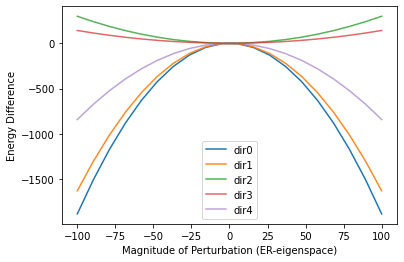

In [21]:
w_wt, v_wt  = np.linalg.eig(w_ER_wt_alt)
print(w_ER_wt_alt)
print(w_wt)
print(v_wt)
energy_vs_w_ER_wt_perturb = []
for move_dim in range(latent_dim):
    trans_seq_full_mag = []
    energy_vs_w_ER_wt_perturb.append([])
    for i,mag in enumerate(pert_mags):    
        trans_seq_full_out = ER_perturb(ref_seq, w_wt, v_wt, pert_mag=mag, pert_dir=move_dim)
        trans_seq_full_mag.append(trans_seq_full_out)  
    for trans_seq_full in trans_seq_full_mag:
         energy_vs_w_ER_wt_perturb[-1].append(energy_diff(i1i2,trans_seq_full,ref_seq,w_ER_wt_alt))

fig = plt.figure()
for i in range(latent_dim):
    plt.plot(pert_mags, energy_vs_w_ER_wt_perturb[i], alpha = 1-.1*i, label='dir%d' % i)
#     print(energy_vs_pc[i])  # shows they are NOT SYMMETRIC
plt.xlabel('Magnitude of Perturbation (ER-eigenspace)')
plt.ylabel('Energy Difference')
plt.legend()
plt.show()

(5, 1532)
(10, 5, 5)
(10, 5, 5)


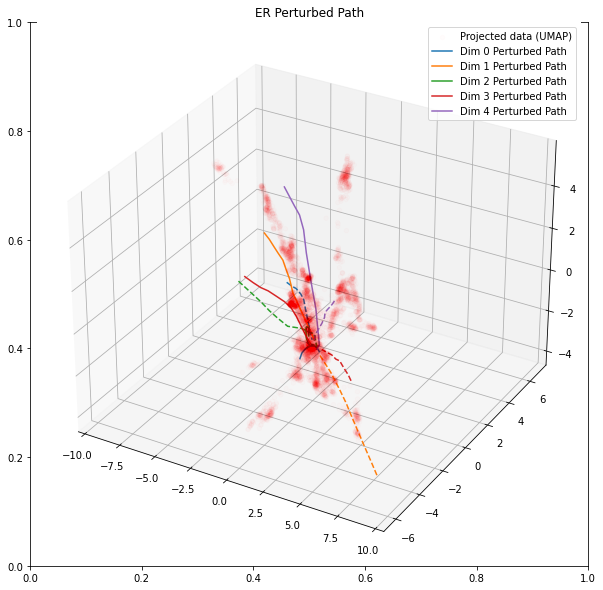

In [22]:
wER_wt_trans_seq_full = []
for i,mag in enumerate(pert_mags):    
    wER_wt_trans_seq_full.append([])
    for move_dim in range(latent_dim):
        trans_seq_full_out = ER_perturb(ref_seq, w_wt,v_wt, pert_mag=mag, pert_dir=move_dim)
        wER_wt_trans_seq_full[-1].append(trans_seq_full_out)  

print(np.array(wER_wt_trans_seq_full[0]).shape)

wER_wt_perturb_path_mag = []
wER_wt_perturb_path_mag_neg = []

for i,mag in enumerate(pert_mags):
    if mag>=0:
        wER_wt_perturb_path_mag.append(embedder.transform(wER_wt_trans_seq_full[i]))
    else:
        wER_wt_perturb_path_mag_neg.append(embedder.transform(wER_wt_trans_seq_full[i]))
wER_wt_perturb_path_mag = np.array(wER_wt_perturb_path_mag)
wER_wt_perturb_path_mag_neg = np.array(wER_wt_perturb_path_mag_neg)
print(wER_wt_perturb_path_mag.shape)
print(wER_wt_perturb_path_mag_neg.shape)


fig = plt.figure(figsize=(10,10))
plt.title('ER Perturbed Path')
ax = plt.axes(projection='3d')
ax.scatter(s_proj_umap[:,0], s_proj_umap[:,1], s_proj_umap[:,2], color='r', alpha=0.01, label='Projected data (UMAP)')
dim_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
for move_dim in range(latent_dim):
    ax.plot(wER_wt_perturb_path_mag[:,move_dim,0], wER_wt_perturb_path_mag[:,move_dim,1], wER_wt_perturb_path_mag[:,move_dim,2], color=dim_colors[move_dim],  label='Dim %d Perturbed Path' % move_dim)
    ax.plot(wER_wt_perturb_path_mag_neg[:,move_dim,0], wER_wt_perturb_path_mag_neg[:,move_dim,1], wER_wt_perturb_path_mag_neg[:,move_dim,2], color=dim_colors[move_dim], linestyle='--')

plt.legend()
plt.show()

## Weighted PCA

In [23]:
s_meaned = s_alt_reordered - s_alt_reordered.mean(axis=0)

# calculate weighted covariance using sequence weights
seq_wt_file = '%s/seq_weight_%s_%s.npy' % (processed_data_dir, pdb_id, pfam_id)
seqs_weight = np.load(seq_wt_file)
print('seqs weights: ', seqs_weight.shape)
sw_alt_reordered = np.zeros(len(seqs_weight))
sw_alt_reordered[:len(s_train_indices)] = seqs_weight[s_train_indices]
sw_alt_reordered[len(s_train_indices):] = seqs_weight[s_test_indices]
cov_mat = np.cov(s_meaned , rowvar = False, aweights=sw_alt_reordered)
eigen_values , eigen_vectors = np.linalg.eigh(cov_mat)
print(eigen_vectors.shape)

seqs weights:  (6535,)
(1532, 1532)


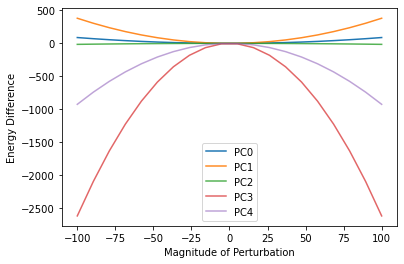

In [24]:
energy_vs_pc_wt = []
for move_dim in range(latent_dim):
    trans_seq_full_mag = []
    energy_vs_pc_wt.append([])
    for i,mag in enumerate(pert_mags):    
        trans_seq_full_out = PCA_perturb(sequence_set, pca_perturb, mag=mag, pc_num=move_dim, components=eigen_vectors)
        trans_seq_full_mag.append(trans_seq_full_out[0])  
    for trans_seq_full in trans_seq_full_mag:
         energy_vs_pc_wt[-1].append(energy_diff(i1i2,trans_seq_full,sequence_set[0],w_ER_alt))

fig = plt.figure()
for i in range(latent_dim):
    plt.plot(pert_mags, energy_vs_pc_wt[i], alpha = 1-.1*i, label='PC%d' % i)
#     print(energy_vs_pc[i])  # shows they are NOT SYMMETRIC
plt.xlabel('Magnitude of Perturbation')
plt.ylabel('Energy Difference')
plt.legend()

In [ ]:
pca_wt_trans_seq_full = []
for i,mag in enumerate(pert_mags):    
    pca_wt_trans_seq_full.append([])
    for move_dim in range(latent_dim):
        trans_seq_full_out = PCA_perturb(sequence_set, pca_perturb, mag=mag, pc_num=move_dim, components=eigen_vectors)
        pca_wt_trans_seq_full[-1].append(trans_seq_full_out[0])  

print(np.array(pca_wt_trans_seq_full[0]).shape)

perturb_path_mag = []
perturb_path_mag_neg = []

for i,mag in enumerate(pert_mags):
    if mag>=0:
        perturb_path_mag.append(embedder.transform(pca_wt_trans_seq_full[i]))
    else:
        perturb_path_mag_neg.append(embedder.transform(pca_wt_trans_seq_full[i]))
perturb_path_mag = np.array(perturb_path_mag)
perturb_path_mag_neg = np.array(perturb_path_mag_neg)
print(perturb_path_mag.shape)
print(perturb_path_mag_neg.shape)


fig = plt.figure(figsize=(10,10))
plt.title('PCA Perturbed Data')
ax = plt.axes(projection='3d')
ax.scatter(s_proj_umap[:,0], s_proj_umap[:,1], s_proj_umap[:,2], color='red', alpha=0.01, label='Projected data (UMAP)')
dim_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
for move_dim in range(latent_dim):
    ax.plot(perturb_path_mag[:,move_dim,0], perturb_path_mag[:,move_dim,1], perturb_path_mag[:,move_dim,2], color=dim_colors[move_dim],  label='Dim %d Perturbed Path' % move_dim)
    ax.plot(perturb_path_mag_neg[:,move_dim,0], perturb_path_mag_neg[:,move_dim,1], perturb_path_mag_neg[:,move_dim,2], color=dim_colors[move_dim], linestyle='--')

plt.legend()
plt.show()

(5, 1532)
(10, 5, 5)
(10, 5, 5)
